# Using ms2deepscore: How to load data, train a model, and compute similarities.

In [1]:
from pathlib import Path
import os

from matchms.importing import load_from_mgf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint)
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from ms2deepscore import SpectrumBinner
from ms2deepscore.data_generators import DataGeneratorAllInchikeys
from ms2deepscore.models import SiameseModel
from ms2deepscore import MS2DeepScore
from ms2deepscore.models import load_model

## Data loading

Here we define the file location of a small sample of spectrums as well as reference scores data.

In [309]:
cols_FN = ['ap_count',
'fr',               
'inst_fr',          
'mean_isi',         
'max_isi',          
'first_thr',        
'mean_thr',         
'median_thr',       
'max_thr',          
'mean_width',       
'median_width',     
'max_width',        
'min_amplitude']

cols_CC = ['ap_count',
           'abs_firing_rate',
           'inst_firing_rate',
           'mean_isi',         
           'max_isi',
           'first_thrs',
           'mean_thrs',         
           'median_thrs',       
           'max_thrs',                  
           'mean_hwidths',
           'median_hwidths', 
           'max_hwidths',
           'mean_amp']


In [2]:

from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

path_cc = "D:/CurrentClamp/all_ephys_CC.csv"
path_fn = "D:/CurrentClamp/all_ephys_feats_FN.csv"
path_waveforrms = "D:/CurrentClamp/waveforms.pkl"
path_waveforrms_cc = "D:/CurrentClamp/CC_waveforms.pkl"


data_ephys_FN = pd.read_csv(path_fn)
data_ephys_CC = pd.read_csv(path_cc)
data_waves_FN = pd.read_pickle(path_waveforrms)
data_waves_CC = pd.read_pickle(path_waveforrms_cc)
data_ephys_CC = data_ephys_CC[data_ephys_CC.columns[1:]] 
data_ephys_FN = data_ephys_FN[data_ephys_FN.columns[1:]] 

data_waves_CC.columns = ['waveforms','trial','exp_name']
data_waves_CC = data_waves_CC[data_waves_CC.trial==1]

In [3]:
FN_LIST = [i[:-3] for i in data_ephys_FN.exp_name]
data_ephys_FN.exp_name = FN_LIST 



data_ephys_CC = data_ephys_CC.dropna()
data_ephys_CC =data_ephys_CC[data_ephys_CC['trialnr']==1.]


data_ephys_CC.filename = [i[:-7] for i in data_ephys_CC.filename]
data_ephys_CC = data_ephys_CC[data_ephys_CC.filename.isin(FN_LIST)]
data_ephys_CC = data_ephys_CC.sort_values('filename')
# data_waves_CC[data_waves_CC] = data_waves_CC[data_waves_CC.trial==1]

In [313]:
cols = ['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude']

first_half = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_first.pkl")
first_half = first_half[first_half.cond=='acsf']
waves_first = first_half['waveform']
first_half = first_half[cols]
# first_half = first_half[cols_FN]

second_half = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_second.pkl")
second_half = second_half[second_half.cond=='acsf']
waves_second = second_half['waveform']
second_half = second_half[cols]
# second_half = second_half[cols_FN]




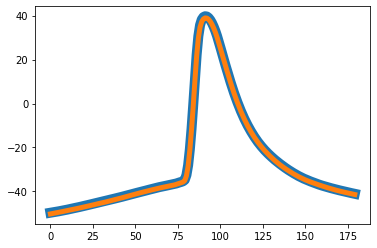

In [291]:
plt.plot(np.mean(first_half,axis=0),linewidth=10)
plt.plot(np.mean(second_half,axis=0),linewidth=5)

<Axes: >

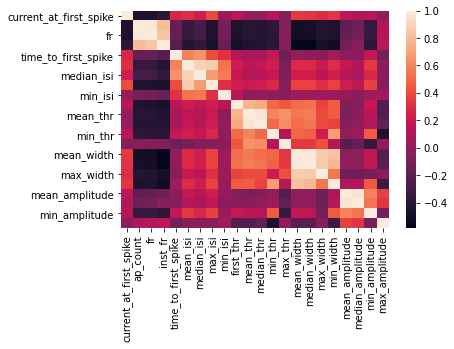

In [101]:
import seaborn as sns
first_half.corr()
sns.heatmap(first_half.corr())

Index(['current_first_spike', 'ap_count', 'abs_firing_rate',
       'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'max_isi',
       'min_isi', 'median_isi', 'first_thrs', 'mean_thrs', 'max_thrs',
       'min_thrs', 'median_thrs', 'first_hwidths', 'mean_hwidths',
       'median_hwidths', 'max_hwidths', 'min_hwidths', 'first_amp', 'mean_amp',
       'median_amp', 'max_amp', 'min_amp', 'trialnr', 'filename', 'waveforms'],
      dtype='object')


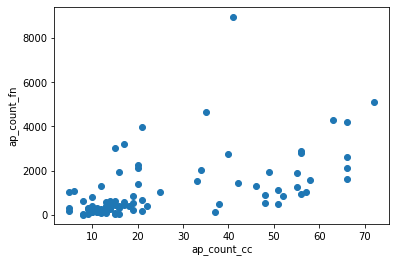

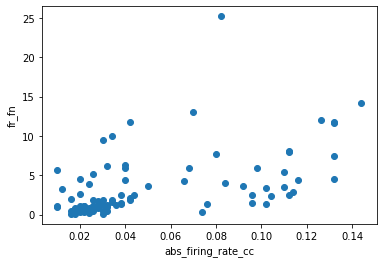

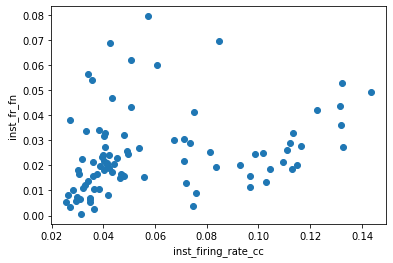

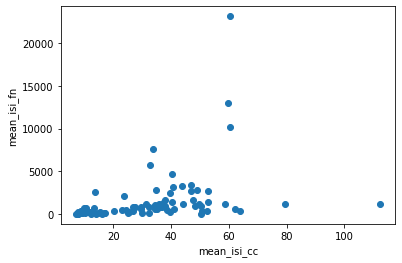

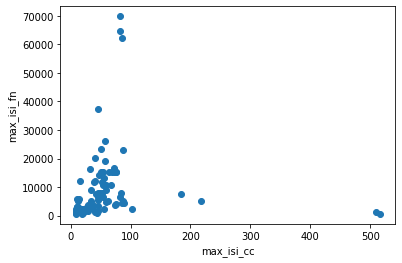

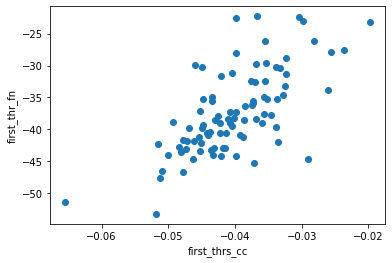

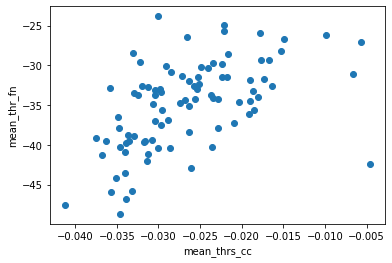

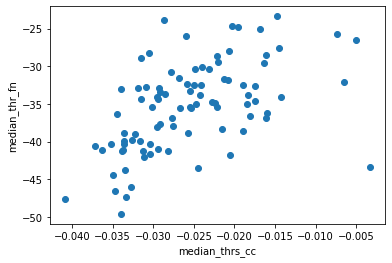

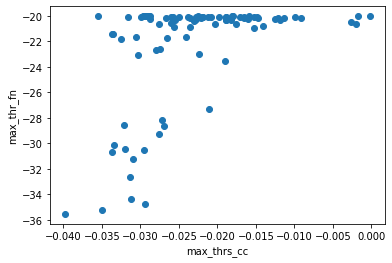

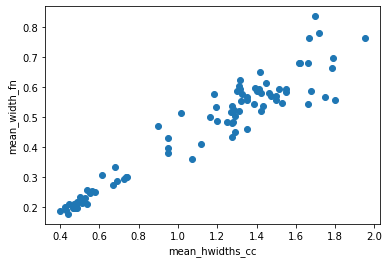

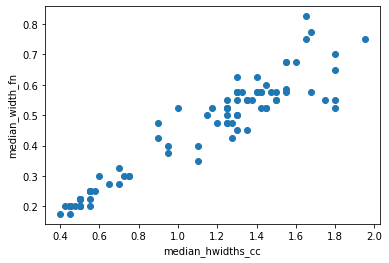

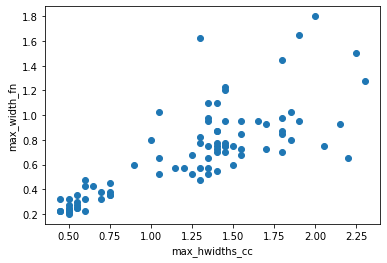

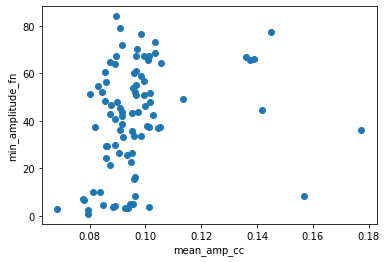

In [250]:
print(data_CC.columns)

# data_cc_temp = data_CC[['current_first_spike', 'ap_count', 'abs_firing_rate',
#        'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'max_isi',
#        'min_isi', 'median_isi', 'first_thrs', 'mean_thrs', 'max_thrs',
#        'min_thrs', 'median_thrs', 'mean_hwidths',
#        'median_hwidths', 'max_hwidths', 'min_hwidths', 'mean_amp',
#        'median_amp', 'max_amp', 'min_amp']]
# data_fn_temp = data_FN[['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
#        'time_to_first_spike', 'mean_isi', 'max_isi', 'min_isi','median_isi',
#        'first_thr', 'mean_thr','max_thr',  'min_thr', 'median_thr',
#        'mean_width', 'median_width', 'max_width', 'min_width',
#        'mean_amplitude', 'median_amplitude', 'max_amplitude', 'min_amplitude']]
data_cc_temp = data_CC[cols_CC]
data_fn_temp = data_FN[cols_FN]  
def standardize(data):
    return (data-np.mean(data))/np.std(data)
for i,j in zip(data_cc_temp.columns,data_fn_temp.columns):
    plt.scatter(data_cc_temp[i],data_fn_temp[j])
    plt.xlabel(i+'_cc')
    plt.ylabel(j+'_fn')
    plt.show()

In [13]:
data_all_CC =data_CC[['current_first_spike', 'ap_count', 'abs_firing_rate',
       'inst_firing_rate', 'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi',
       'min_isi', 'first_thrs', 'mean_thrs', 'median_thrs',
       'min_thrs', 'max_thrs', 'mean_hwidths',
       'median_hwidths', 'max_hwidths', 'min_hwidths', 'mean_amp',
       'median_amp', 'min_amp', 'max_amp']]
# data_all_CC = np.array([np.hstack(i) for i in data_all_CC])
data_all_CC.columns = ['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',
        ]
data_all_FN =data_FN[['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',
        ]]

corrs_sig = data_all_FN.corrwith(data_all_CC)[data_all_FN.corrwith(data_all_CC)>0.2]
# inds = data_all_FN.corrwith(data_all_CC).index
# inds[corrs_sig]
corrs_sig
# data_all_FN = np.array([np.hstack(i) for i in data_all_FN])

NameError: name 'data_CC' is not defined

In [21]:
import numpy as np
from sklearn.decomposition import PCA
X_CC = data_cc_temp.to_numpy() #data_all_CC
X_FN = data_fn_temp.to_numpy() #data_all_FN


pca = PCA(min(X_FN.shape[1],X_CC.shape[1]))
FN_transform =X_FN# pca.fit_transform(X_FN)
CC_transform =X_CC# pca.fit_transform(X_CC)


NameError: name 'data_cc_temp' is not defined

In [314]:
X_FN_first_half = [first_half.to_numpy()[0] for i in range(len(first_half)) ] #data_all_FN
X_FN_first_half = np.array(X_FN_first_half,dtype=np.float32)
X_FN_second_half = [second_half.to_numpy()[0] for i in range(len(second_half)) ] #data_all_FN
X_FN_second_half = np.array(X_FN_second_half,dtype=np.float32)


In [128]:
def return_shuffled_inds(ind1,ind2):
    SHUFFLED = True

    while SHUFFLED:
        indices_rand1 = ind1
        indices_rand2 = ind2
        np.random.shuffle(indices_rand1)
        np.random.shuffle(indices_rand2)
        if len(np.where(indices_rand1-indices_rand2==0)[0])==0:
            SHUFFLED=False
    return ind1,ind2
        # print('here')
idx1,idx2 = return_shuffled_inds(np.arange(90),np.arange(90))

In [190]:
FN_X = np.vstack([FN_transform,FN_transform[indices_rand1]])
CC_X = np.vstack([CC_transform,CC_transform[indices_rand2]])
y = np.hstack([np.ones(90),np.zeros(90)])


In [315]:
indices_rand1,indices_rand2 = return_shuffled_inds(np.arange(len(X_FN_first_half)),np.arange(len(X_FN_first_half)))
first_half = np.vstack([X_FN_first_half,X_FN_first_half[indices_rand1]])
second_half = np.vstack([X_FN_second_half,X_FN_second_half[indices_rand2]])
y = np.hstack([np.ones(len(X_FN_first_half)),np.zeros(len(X_FN_first_half))])

In [298]:
indices_rand1,indices_rand2 = return_shuffled_inds(np.arange(len(waves_first)),np.arange(len(waves_first)))
waves_first  = np.vstack(waves_first.to_numpy())
waves_second = np.vstack(waves_second.to_numpy())
first_half   = np.vstack([waves_first,waves_first[indices_rand1]])
second_half  = np.vstack([waves_second,waves_second[indices_rand2]])
y = np.hstack([np.ones(len(waves_first)),np.zeros(len(waves_first))])

In [118]:
all_idx = np.arange(len(FN_X))
# np.random.shuffle(all_idx)
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split


X1_train,X1_test,X2_train,X2_test, y_train, y_test = train_test_split(FN_X,CC_X, y, test_size=0.33, random_state=42)# kf = KFold(n_splits=2)


NameError: name 'FN_X' is not defined

In [316]:

X1_train,X1_test,X2_train,X2_test, y_train, y_test = train_test_split(first_half,second_half, y, test_size=0.33, random_state=42)# kf = KFold(n_splits=2)

In [317]:
X1_train =np.vstack(X1_train)
X2_train =np.vstack(X2_train)
y_train =np.hstack(y_train)
X1_test =np.vstack(X1_test)
X2_test =np.vstack(X2_test)
y_test =np.hstack(y_test)


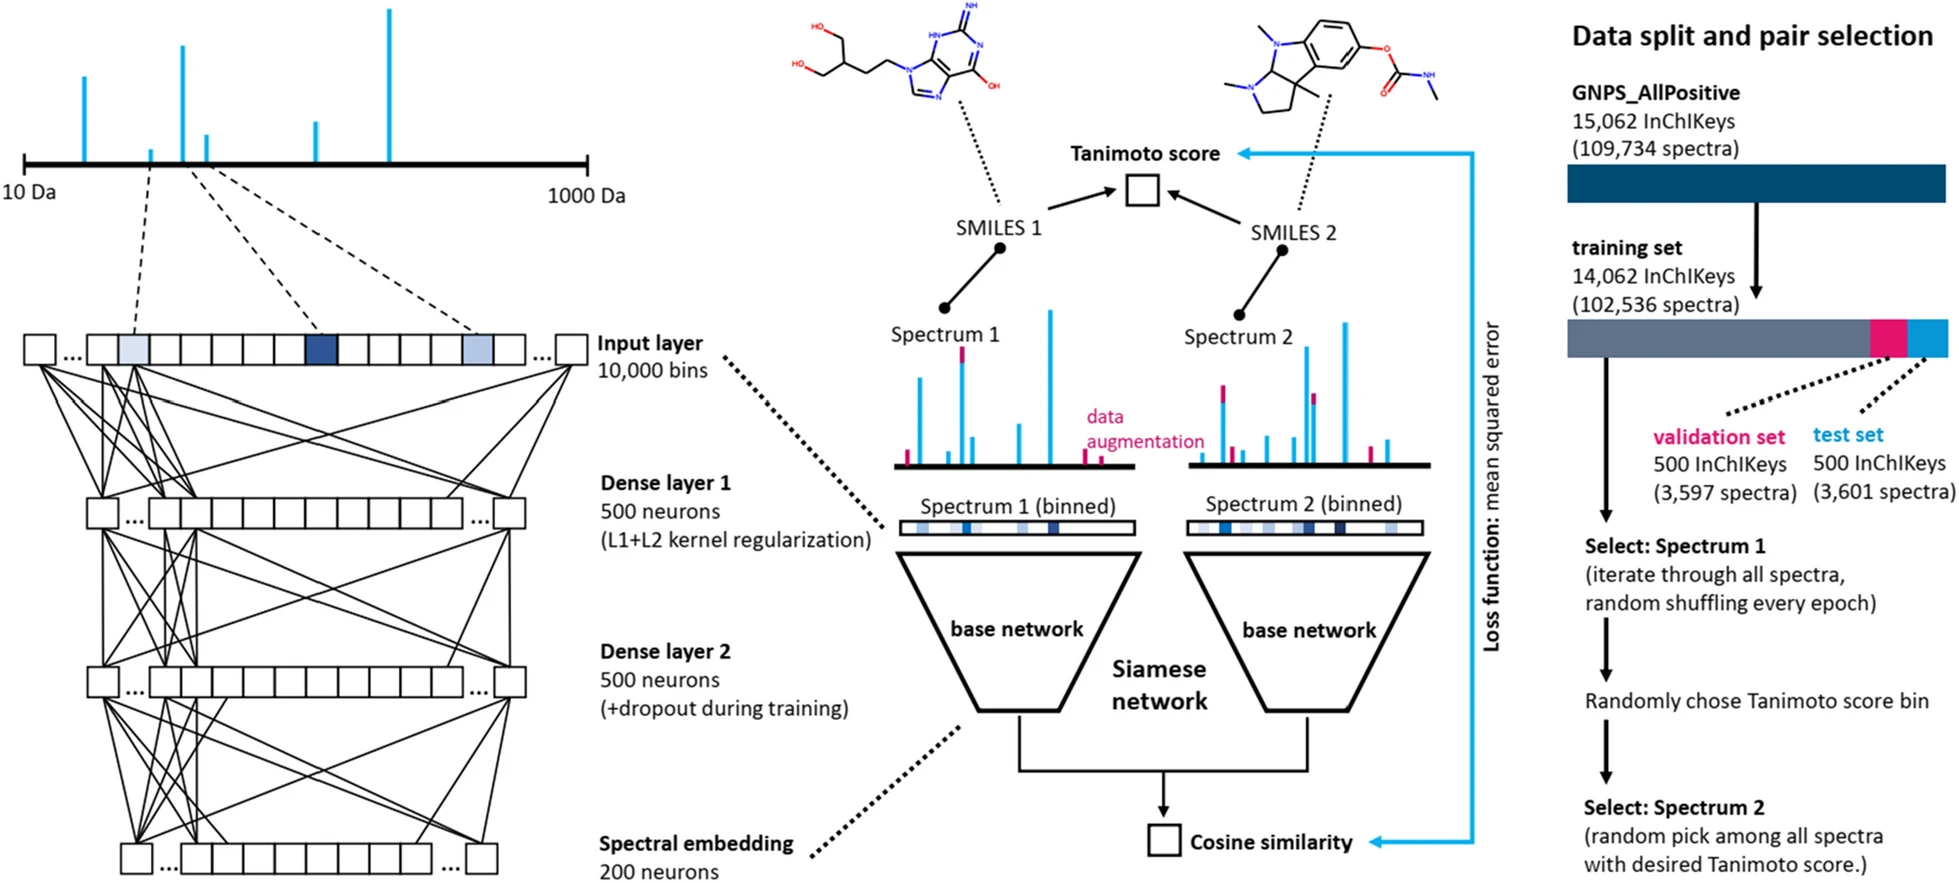

## Model training

Initialize a SiameseModel. It consists of a dense 'base' network that produces an embedding for each of the 2 inputs. The 'head' model computes the cosine similarity between the embeddings.

In [321]:
model = SiameseModel(22, base_dims=(15, 15), embedding_dim=10,
                         dropout_rate=0.5,seperate_base=False)
model.compile(loss='mse', optimizer=Adam(learning_rate=0.01), metrics=["mae", "mse"])

# Save best model and include earlystopping
earlystopper_scoring_net = EarlyStopping(monitor='val_mse', mode="min", patience=10, verbose=1, restore_best_weights=True)
model.summary()

Model: "base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 22)]              0         
                                                                 
 dense1 (Dense)              (None, 15)                345       
                                                                 
 normalization1 (BatchNorma  (None, 15)                60        
 lization)                                                       
                                                                 
 dense2 (Dense)              (None, 15)                240       
                                                                 
 normalization2 (BatchNorma  (None, 15)                60        
 lization)                                                       
                                                                 
 dropout2 (Dropout)          (None, 15)                0      

Train the model. The model will continue for 150 epochs or will stop if the validation loss did not decrease for 10 epochs.

In [322]:
history = model.model.fit(x={'input_a':X1_train,'input_b':X2_train},y=y_train.astype('float32'), 
                          validation_data=({'input_a':X1_test,'input_b':X2_test},y_test),
                          epochs=200, 
                          verbose=1, )
                        #   callbacks=[earlystopper_scoring_net])

Epoch 1/200
19/19 [==============================] - 8s 46ms/step - loss: 0.3534 - mae: 0.5180 - mse: 0.3533 - val_loss: 0.4869 - val_mae: 0.4932 - val_mse: 0.4868
Epoch 2/200
19/19 [==============================] - 0s 19ms/step - loss: 0.2899 - mae: 0.4978 - mse: 0.2899 - val_loss: 0.4784 - val_mae: 0.4933 - val_mse: 0.4783
Epoch 3/200
19/19 [==============================] - 0s 12ms/step - loss: 0.3041 - mae: 0.5128 - mse: 0.3040 - val_loss: 0.4822 - val_mae: 0.4933 - val_mse: 0.4821
Epoch 4/200
19/19 [==============================] - 0s 17ms/step - loss: 0.2830 - mae: 0.4956 - mse: 0.2830 - val_loss: 0.3274 - val_mae: 0.4961 - val_mse: 0.3274
Epoch 5/200
19/19 [==============================] - 0s 13ms/step - loss: 0.2838 - mae: 0.4965 - mse: 0.2837 - val_loss: 0.3533 - val_mae: 0.5043 - val_mse: 0.3533
Epoch 6/200
19/19 [==============================] - 0s 19ms/step - loss: 0.2848 - mae: 0.4962 - mse: 0.2847 - val_loss: 0.3214 - val_mae: 0.4962 - val_mse: 0.3213
Epoch 7/200
19/1

Plot the validation and training loss, to check for overfitting.

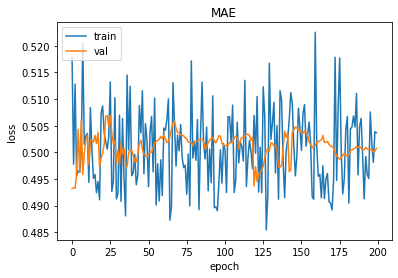

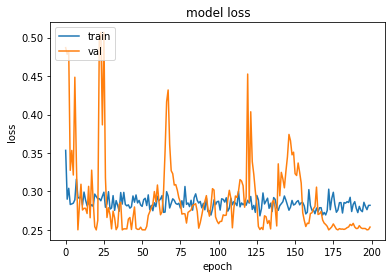

In [324]:
from matplotlib import pyplot as plt

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('MAE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()